In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
import matplotlib.patches as patches
from collections import namedtuple
from matplotlib import cm
import time

from IPython.display import display, clear_output

In [25]:
OptimizationState = namedtuple('OptimizationState', ['error_history','max_iterations'])
IterationState = namedtuple('IterationState', ['iteration','m','b','dEdm', 'dEdb','yhat','errors','mean_error'])
OptimalModel = namedtuple('Model', ['m', 'b','error'])

PlotState = namedtuple('PlotState', ['figure','axes','legends'])

# FUNCIONES

In [26]:
def optimal_model(x,y):   
    from sklearn import datasets, linear_model
    regr = linear_model.LinearRegression()
    regr.fit(x.reshape(-1, 1),y)
    optimal_m=regr.coef_[0]
    optimal_b=regr.intercept_
    optimal_yhat=x*optimal_m+optimal_b
    optimal_error=((optimal_yhat-y)**2).mean()
    
    return OptimalModel(optimal_m,optimal_b,optimal_error)

In [27]:
def init_data(ax_data,x,y,optimal,m,b):
    ax_data.scatter(x,y,color="blue")
    
    x_pad=10
    min_x,max_x=x.min()-x_pad,x.max()+x_pad
    ax_data.plot([min_x,max_x],[min_x*optimal.m+optimal.b,max_x*optimal.m+optimal.b],color="cyan")
    ax_data.plot([min_x,max_x],[min_x*m+b,max_x*m+b],color="red")
    
    ax_data.set_xlabel("x")
    ax_data.set_ylabel("y")

In [28]:
def init_error_history(ax_error):
    ax_error.set_xlabel("Iteración")
    ax_error.set_ylabel("Error")
    ax_error.set_title("Historial de Error")

In [29]:
def init_contour(ax_contour,x,y,optimal,m,b):    
    ax_contour.set_xlabel("m")
    ax_contour.set_ylabel("b")
    
    # ax3.set_zlabel("E")
    ax_contour.set_title("Contorno de E(m,b) ")
    detail=0.05
    param_range=4
    M = np.arange(-4, 4, detail)
    B = np.arange(-4, 4, detail)
    Ms, Bs = np.meshgrid(M, B)
    E=np.zeros_like(Ms)
    n=len(x)
    
    for i in range(n):
        Yi=Ms*x[i]+Bs
        E+=(Yi-y[i])**2
    
    E/=n
    
    # ax_contour.contour(Ms,Bs,E, 14, linewidths=0.5, colors='k') # lineas del contorno
    surf=ax_contour.contourf(Ms,Bs,E,25, cmap='hot')# 4to parámetro= aumentar detalle
    
    ax_contour.scatter([optimal.m], [optimal.b],c="green", s=50)
    plt.colorbar(surf, shrink=0.4, aspect=5)

In [30]:
def init_plot(x,y,optimal,m,b):
    
    figure=plt.figure(dpi=100)
    plt.suptitle('Entrenamiento de modelo lineal')
    ax_data=figure.add_subplot(1,3,1)
    ax_error=figure.add_subplot(1,3,2)
    ax_contour=figure.add_subplot(1,3,3)#,projection='3d')
    axes=(ax_data,ax_error,ax_contour)
    
    init_data(ax_data,x,y,optimal,m,b)
    init_error_history(ax_error)
    init_contour(ax_contour,x,y,optimal,m,b)
    
    plt.show()
     
    return PlotState(figure,axes,None)

In [31]:
def visualizar(plot_state,x,y,iteration_state,optimal,optimization_state):
    (ax1,ax2,ax3)=plot_state.axes
    # Visualizacion
    
    #actualizar linea del modelo actual
    ax1.lines.pop()
    x_pad=10
    min_x,max_x=x.min()-x_pad,x.max()+x_pad
    ax1.plot([min_x,max_x],[min_x*m+b,max_x*m+b],color="red")
    # ax3.scatter(iteration_state.m, iteration_state.b, iteration_state.mean_error,c="black",s=50)
    ax3.scatter([iteration_state.m], [iteration_state.b],c="white",s=40)
    
    # Mostrar leyendas
    model = patches.Patch(color='red', label='Modelo: y=x*({:.2f})+({:.2f})'.format(iteration_state.m,iteration_state.b))
    model_true = patches.Patch(color='cyan', label='Modelo óptimo: y=x*({:.2f})+({:.2f})'.format(optimal.m,optimal.b))
    label='$\\frac{ \\partial E}{\\partial m}=$ %.2f, $\\frac{ \\partial E}{\\partial b}$ %.2f' %(iteration_state.dEdm,iteration_state.dEdb)
    derivatives = patches.Patch(color='red', label=label)
    error_patch = patches.Patch(color='red', label='$E=\\frac{1}{n} \sum_i^n E_i=$ %.2f' % (iteration_state.mean_error))
    optimal_error = patches.Patch(color='cyan', label='E del modelo óptimo: %.2f' % (optimal.error))
    handles=[model,derivatives,error_patch,model_true,optimal_error]
    ax1.legend(handles=handles)
    
    ax2.lines.clear()
    ax2.plot(optimization_state.error_history,color="blue")
    
    ax1.set_title("Iteración %03d / %03d" % (iteration_state.iteration+1,optimization_state.max_iterations))
    
    plt.show()

# Carga de datos

In [32]:
dataset_base="https://github.com/KevinFDI/IML_Practica_2/tree/main/datasets"
dataset="https://raw.githubusercontent.com/KevinFDI/IML_Practica_2/main/datasets/study_regression_small.csv"

In [33]:
import urllib

data = urllib.request.urlopen(dataset)
data=np.loadtxt(data, delimiter=",", skiprows=1)
x,y=data[:,0],data[:,1]


# PARÁMETROS

**Normalizar**

In [34]:
NORMALIZAR= 1
if (NORMALIZAR):
    x= (x - x.mean()) / x.std()
    y= (y - y.mean()) / y.std()

Configuración del descenso de gradiente

**Parámetros iniciales del modelo (probar valores entre -5 y 5)**

In [35]:
m= 2
b= -3

Iteraciones máximas a realizar


In [36]:
max_iterations= 300

Minimo de tolerancia para el cambio del error entre iteraciones

In [37]:
tolerance=0.0000001

Velocidad de aprendizaje


Valores sensatos: entre 0.00001 y 0.001

In [38]:
alpha= 0.007

Velocidad de visualización

In [39]:
fps= 10
plot_jumps= 5

Fin Configuración

Cálculo del valor óptimo mediante cuadrados mínimos

In [40]:
optimal=optimal_model(x,y)

Fin cálculo del valor óptimo mediante cuadrados mínimos

# INICIALIAZACIÓN DEL ALGORITMO

In [41]:
iteration=0
mean_error_last=tolerance+1
mean_error=0
error_history=[]

Fin inicialización del algoritmo

Opciones de visualización 

In [42]:
plt.ion()

Fin opciones de visualización

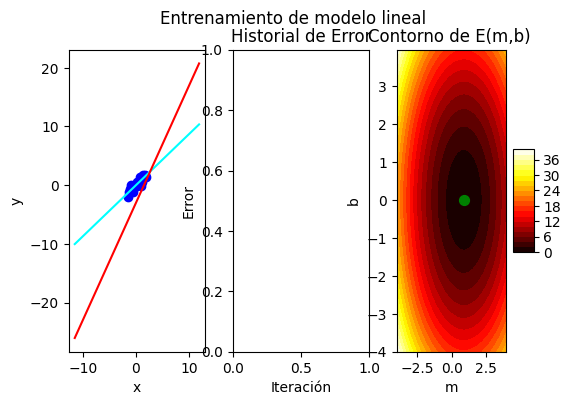

In [43]:
plot_state=init_plot(x,y,optimal,m,b)
optimization_state= OptimizationState(max_iterations=max_iterations,error_history=[])

# DECENSO DE GRADIENTE

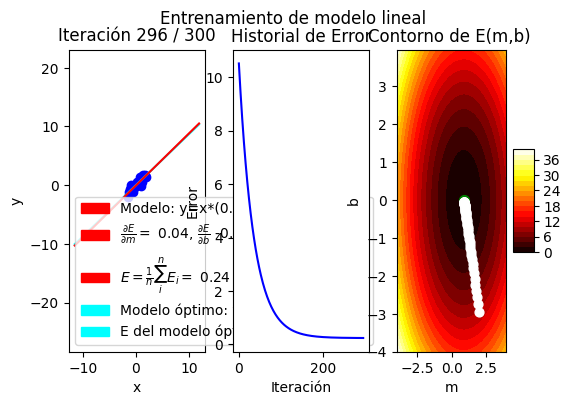

In [44]:
while iteration<optimization_state.max_iterations and abs(mean_error_last-mean_error)>tolerance:
    
    #DESCENSO DE GRADIENTE
    #predicciones del modelo
    yhat=x*m+b
    # calculo de derivadas
    dEdm=2*((yhat-y)*x).mean()
    dEdb=2*(yhat-y).mean()
    #actualizo los parámetros
    m=m-alpha*dEdm
    b=b-alpha*dEdb
    # FIN DESCENSO DE GRADIENTE
    
    #CALCULO DE ERROR
    #Calculo del error del modelo
    errors= (y-yhat)**2
    mean_error_last=mean_error
    mean_error=errors.mean()
    optimization_state.error_history.append(mean_error)
    #FIN CALCULO DE ERROR
    
    #visualización
    if (iteration % plot_jumps ==0):
        iteration_state=IterationState(iteration,m,b,dEdm, dEdb,yhat,errors,mean_error)
        visualizar(plot_state,x,y,iteration_state,optimal,optimization_state)
        plt.pause(1/fps)
    # fin visualización
    plt.show()
    iteration+=1

display(plot_state.figure)
clear_output(wait = True)